# Import Libraries

In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torchvision import datasets, transforms
import torchvision

import sys, os
import matplotlib.pyplot as plt

import numpy as np
import random


import custom_resnet

from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR

from modular.create_data_loader import create_train_data_loader, create_test_data_loader
from modular.dataloader import Cifar10SearchDataset
from modular.transforms import CustomResnetTransforms
from modular.train import model_training, model_testing
from modular.plots import plot_losses,plot_images 

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

import warnings
warnings.filterwarnings('ignore')

In [2]:
### this is for running in local ###
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
device = torch.device("cuda" if cuda else "cpu")
print(device)

CUDA Available? True
cuda


# Transformation of Data

In [4]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

# Dataset and Creating Train/Test Split

In [5]:
train = Cifar10SearchDataset('./data', train=True, download=True, transform=train_transforms)
test = Cifar10SearchDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=1024, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

print (len(train_loader),len(test_loader))

49 10


# Model Params for Custom Resnet
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
m = custom_resnet.resnet_model().to(device)
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## Calculating the max and min LR using one cycle LR policy

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.66E-03


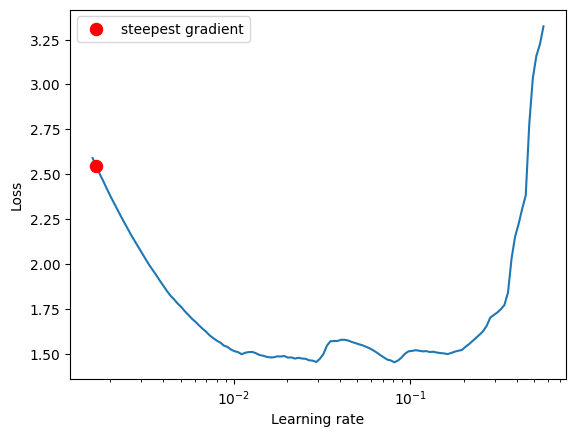

SystemExit: 

In [8]:
m = custom_resnet.resnet_model().to(device)
optimizer = optim.Adam(m.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(m, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state
sys.exit()

# Let's Train and test our model
### using one cycle lr policy

In [9]:
EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=1.66E-03,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start= 5.0/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear',
    )


In [11]:
for epoch in range(EPOCHS):
    printmd("**EPOCH: "+ str(epoch)+"**"),
    train_acc,train_losses = model_training(m, device, train_loader, optimizer, epoch, scheduler, criterion)
    test_acc,test_losses,miss_classified_data = model_testing(m, device, test_loader, criterion)

**EPOCH: 0**

Loss=1.3479211330413818 LR =0.0003466270491803279 Batch_id=48 Accuracy=39.63: 100% 49/49 [00:08<00:00,  5.86it/s] 



Test set: Average loss: 0.0013, Accuracy: 5396/10000 (53.96%)



**EPOCH: 1**

Loss=0.977191150188446 LR =0.0006766540983606557 Batch_id=48 Accuracy=61.82: 100% 49/49 [00:08<00:00,  5.82it/s]  



Test set: Average loss: 0.0012, Accuracy: 5715/10000 (57.15%)



**EPOCH: 2**

Loss=0.7496570348739624 LR =0.0010066811475409835 Batch_id=48 Accuracy=71.31: 100% 49/49 [00:08<00:00,  5.78it/s]



Test set: Average loss: 0.0010, Accuracy: 6696/10000 (66.96%)



**EPOCH: 3**

Loss=0.6887334585189819 LR =0.0013367081967213116 Batch_id=48 Accuracy=76.46: 100% 49/49 [00:08<00:00,  5.67it/s]



Test set: Average loss: 0.0007, Accuracy: 7416/10000 (74.16%)



**EPOCH: 4**

Loss=0.5918386578559875 LR =0.001658217149301826 Batch_id=48 Accuracy=79.65: 100% 49/49 [00:08<00:00,  5.72it/s] 



Test set: Average loss: 0.0007, Accuracy: 7496/10000 (74.96%)



**EPOCH: 5**

Loss=0.513748824596405 LR =0.0015708574650912996 Batch_id=48 Accuracy=82.55: 100% 49/49 [00:08<00:00,  5.48it/s]  



Test set: Average loss: 0.0005, Accuracy: 8254/10000 (82.54%)



**EPOCH: 6**

Loss=0.38931429386138916 LR =0.0014834977808807733 Batch_id=48 Accuracy=85.46: 100% 49/49 [00:08<00:00,  5.80it/s]



Test set: Average loss: 0.0006, Accuracy: 8084/10000 (80.84%)



**EPOCH: 7**

Loss=0.3673771917819977 LR =0.001396138096670247 Batch_id=48 Accuracy=86.75: 100% 49/49 [00:08<00:00,  5.74it/s]  



Test set: Average loss: 0.0004, Accuracy: 8469/10000 (84.69%)



**EPOCH: 8**

Loss=0.37721896171569824 LR =0.0013087784124597207 Batch_id=48 Accuracy=88.23: 100% 49/49 [00:08<00:00,  5.81it/s]



Test set: Average loss: 0.0005, Accuracy: 8367/10000 (83.67%)



**EPOCH: 9**

Loss=0.28562217950820923 LR =0.0012214187282491944 Batch_id=48 Accuracy=89.70: 100% 49/49 [00:08<00:00,  5.73it/s]



Test set: Average loss: 0.0004, Accuracy: 8619/10000 (86.19%)



**EPOCH: 10**

Loss=0.3330799639225006 LR =0.001134059044038668 Batch_id=48 Accuracy=90.58: 100% 49/49 [00:08<00:00,  5.84it/s]  



Test set: Average loss: 0.0005, Accuracy: 8444/10000 (84.44%)



**EPOCH: 11**

Loss=0.26914840936660767 LR =0.0010466993598281418 Batch_id=48 Accuracy=90.99: 100% 49/49 [00:08<00:00,  5.62it/s]



Test set: Average loss: 0.0005, Accuracy: 8479/10000 (84.79%)



**EPOCH: 12**

Loss=0.21861952543258667 LR =0.0009593396756176155 Batch_id=48 Accuracy=91.95: 100% 49/49 [00:08<00:00,  5.60it/s]



Test set: Average loss: 0.0004, Accuracy: 8695/10000 (86.95%)



**EPOCH: 13**

Loss=0.16981394588947296 LR =0.0008719799914070892 Batch_id=48 Accuracy=92.64: 100% 49/49 [00:08<00:00,  5.74it/s]



Test set: Average loss: 0.0004, Accuracy: 8826/10000 (88.26%)



**EPOCH: 14**

Loss=0.1732415109872818 LR =0.0007846203071965628 Batch_id=48 Accuracy=93.18: 100% 49/49 [00:08<00:00,  5.89it/s] 



Test set: Average loss: 0.0004, Accuracy: 8757/10000 (87.57%)



**EPOCH: 15**

Loss=0.1525152176618576 LR =0.0006972606229860366 Batch_id=48 Accuracy=93.80: 100% 49/49 [00:08<00:00,  5.64it/s] 



Test set: Average loss: 0.0003, Accuracy: 8879/10000 (88.79%)



**EPOCH: 16**

Loss=0.16108545660972595 LR =0.0006099009387755103 Batch_id=48 Accuracy=94.65: 100% 49/49 [00:08<00:00,  5.77it/s]



Test set: Average loss: 0.0003, Accuracy: 8919/10000 (89.19%)



**EPOCH: 17**

Loss=0.16818435490131378 LR =0.000522541254564984 Batch_id=48 Accuracy=95.35: 100% 49/49 [00:08<00:00,  5.82it/s] 



Test set: Average loss: 0.0004, Accuracy: 8828/10000 (88.28%)



**EPOCH: 18**

Loss=0.16709598898887634 LR =0.00043518157035445744 Batch_id=48 Accuracy=95.89: 100% 49/49 [00:08<00:00,  5.58it/s]



Test set: Average loss: 0.0003, Accuracy: 8968/10000 (89.68%)



**EPOCH: 19**

Loss=0.11603788286447525 LR =0.00034782188614393135 Batch_id=48 Accuracy=96.59: 100% 49/49 [00:08<00:00,  5.68it/s]



Test set: Average loss: 0.0003, Accuracy: 9112/10000 (91.12%)



**EPOCH: 20**

Loss=0.11375141143798828 LR =0.0002604622019334048 Batch_id=48 Accuracy=97.10: 100% 49/49 [00:08<00:00,  5.86it/s] 



Test set: Average loss: 0.0003, Accuracy: 9142/10000 (91.42%)



**EPOCH: 21**

Loss=0.06924860924482346 LR =0.00017310251772287874 Batch_id=48 Accuracy=97.74: 100% 49/49 [00:08<00:00,  5.86it/s] 



Test set: Average loss: 0.0002, Accuracy: 9204/10000 (92.04%)



**EPOCH: 22**

Loss=0.06565190851688385 LR =8.574283351235222e-05 Batch_id=48 Accuracy=98.20: 100% 49/49 [00:08<00:00,  5.86it/s]  



Test set: Average loss: 0.0002, Accuracy: 9208/10000 (92.08%)



**EPOCH: 23**

Loss=0.040854815393686295 LR =-1.6168506981740875e-06 Batch_id=48 Accuracy=98.52: 100% 49/49 [00:08<00:00,  5.63it/s]



Test set: Average loss: 0.0002, Accuracy: 9277/10000 (92.77%)



## Displaying Train Test Accuracy and Loss Plots

mkdir: cannot create directory ‘images’: File exists


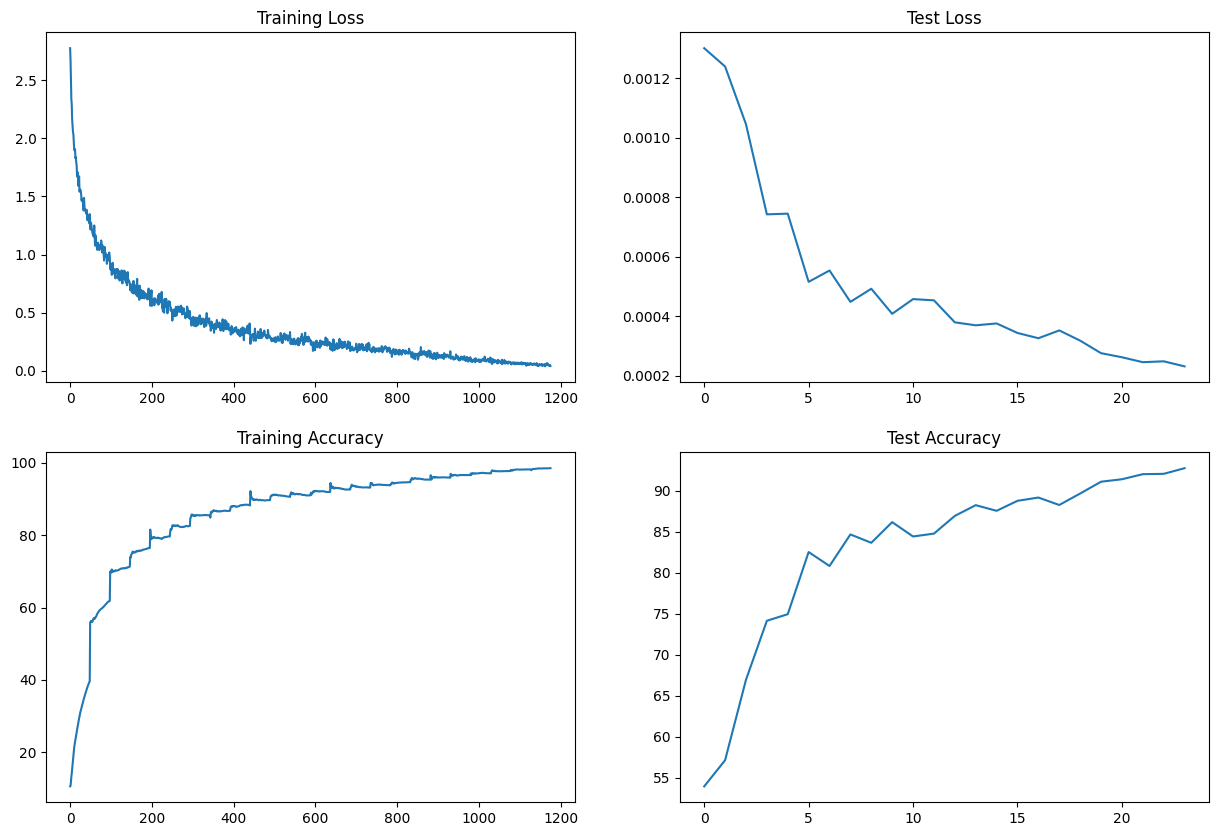

In [12]:
os.system('mkdir images')
fig = plot_losses(train_losses, train_acc, test_losses, test_acc)
fig.savefig('images/Accuracy & Loss.jpg')

## Displaying Sample Miss Classified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

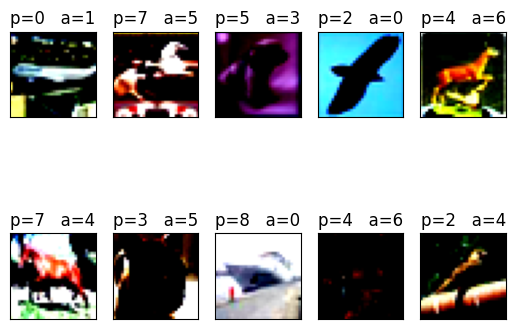

In [15]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

random_images = range(0,len(miss_classified_data[0]))
random_selects = random.sample(random_images, 10)

fig_miss_class = plt.figure()
count=0
for i in random_selects:
    plt.subplot(2,5,count+1)
    plt.imshow(miss_classified_data[2][i].cpu().permute(1,2,0))   
    plt.title("p="+str(miss_classified_data[1][i])+"   "+"a="+str(miss_classified_data[0][i]))
    plt.xticks([])
    plt.yticks([])
    count+=1

fig_miss_class.savefig("images/mis_classified_image.jpg")

## Displaying Sample Train Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

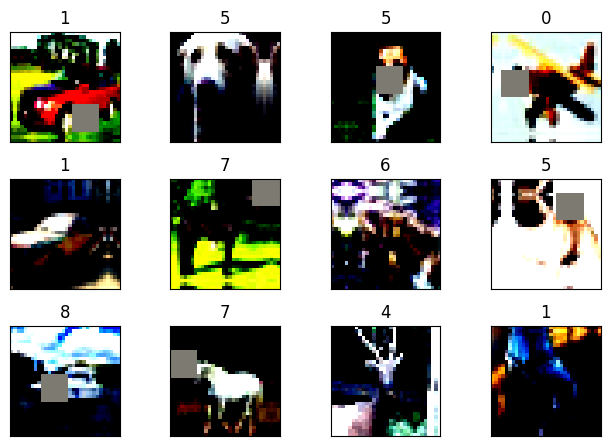

In [16]:
batch_data_train, batch_label_train = next(iter(train_loader))
figure_train = plot_images(batch_data_train, batch_label_train.tolist(), 12, 3, 'CIFAR10')
figure_train.savefig("images/train_dataset.jpg")

## Displaying Sample Test Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

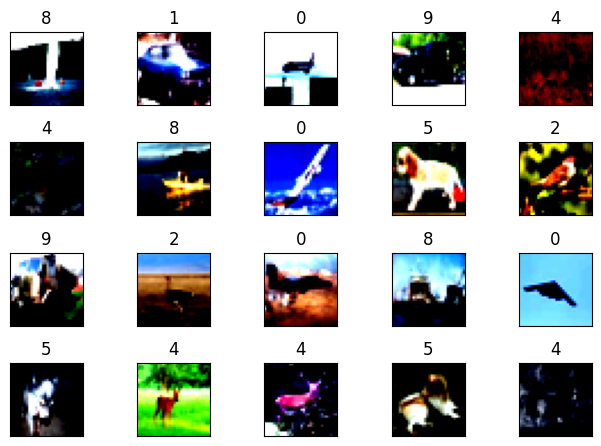

In [17]:
batch_data_test, batch_label_test = next(iter(test_loader))
figure_test = plot_images(batch_data_test, batch_label_test.tolist(), 20, 4, 'CIFAR10')
figure_test.savefig("images/test_dataset.jpg")

**********************************************************